In [1]:
from deeplab3.dataloaders import make_dataset
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import torch

import json
import datetime

from deeplab3.utils import model_utils

font = {'size'   : 16}

matplotlib.rc('font', **font)

Visualize Darkening Effect
----

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/cityscapes_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/'])

Using RGB-D input
Found 500 val images


Text(0.5, 1.0, 'Original')

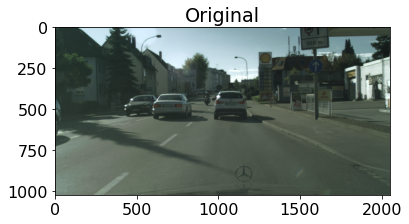

In [3]:
dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(2)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original")

### Different Darkening Degrees

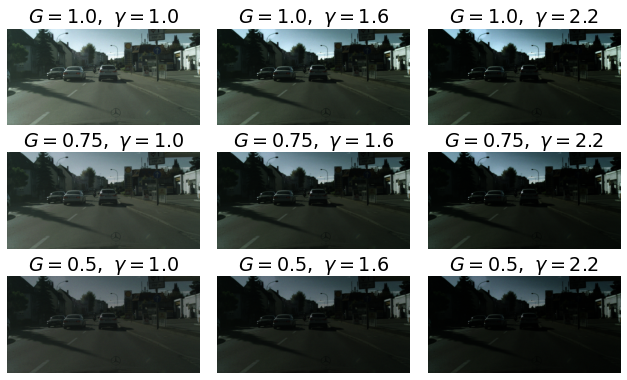

In [9]:
gain = [1.0, 0.75, 0.5]
gamma = [1.0, 1.6, 2.2]

fig = plt.figure(figsize=(9, 5.5))

dark_imgs = []

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        
        dark_imgs.append(processed_sample['image'])
        
        plt.title("$G = {},~\gamma = {}$".format(i, j))
        plt.axis('off')
        
        index += 1
        
plt.tight_layout()

#fig.savefig('figures/cityscapes_dark_grid.eps', format='eps', dpi=300)

### RE-Brightened to visualize noise

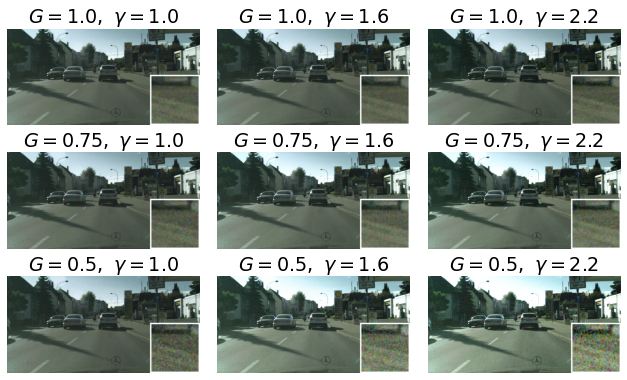

In [7]:
from PIL import Image

fig = plt.figure(figsize=(9, 5.5))

noise_imgs = []

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        h, w = processed_sample['image'].size
        crop = processed_sample['image'].crop((1500,500, 1550, 550))
        crop = crop.resize((500,500), Image.BILINEAR)
        crop = np.array(crop)
        img = np.array(processed_sample['image'])
        img[w-530:w, h-530:h, :] = 255
        img[w-515:w-15, h-515:h-15, :] = crop
        
        noise_imgs.append(Image.fromarray(img))
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(img)
        plt.title("$G = {},~\gamma = {}$".format(i, j))
        plt.axis('off')
        index += 1
        
plt.tight_layout()

#fig.savefig('figures/cityscapes_noise_grid.eps', format='eps', dpi=300)

In [10]:
img = noise_imgs[0]
img.save(fp='figures/cityscapes_noise.gif', format='GIF', append_images=noise_imgs[1:],
         save_all=True, duration=200, loop=0)

img = dark_imgs[0]
img.save(fp='figures/cityscapes_dark.gif', format='GIF', append_images=dark_imgs[1:],
         save_all=True, duration=200, loop=0)

## Compute Histogram of Darkened Dataset

In [6]:
from tqdm import tqdm 

def sample_distribution(dataset, cfg, n=100, channels=4):
    n = min(n, len(dataset))
    m = 100

    samples = np.zeros((m*n,channels))
    random_it = np.random.choice(len(dataset), n)
    for it, i in tqdm(enumerate(random_it)):
        img_path, depth_path, label_path = dataset.get_path(i)
        sample = dataset.loader.get_sample(img_path, depth_path, label_path)
        
        f = tr.Darken(cfg)
        sample = tr.ToTensor()(f(sample))
        
        if channels == 4 :
            sample['image'] = torch.cat((sample['image'], sample['depth'].unsqueeze(0)), 0)
        
        if isinstance(sample['image'], list):
            img = [np.asarray(img) for img in sample['image']]
            img = np.concatenate(img, axis=2)
        else:
            img = np.asarray(sample['image'])

        #Flatten image
        img = np.transpose(img, (1,2,0))
        img = np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2]))
        if img.shape[0]>m:
            pixel_i = np.random.choice(img.shape[0], m)
            samples[it*m:(it+1)*m,:] = img[pixel_i, :]

    mean = np.mean(samples, axis=0)
    std = np.std(samples, axis=0)
    m_max = np.max(samples, axis=0)
    median = np.median(samples, axis=0)

    # if dataset.mode == "RGBD":
    #     import matplotlib.pyplot as plt
    #     plt.hist(samples[:, -1], bins='auto')
    #     plt.title("Depth histogram")
    #     plt.show()

    return {'mean': mean, 'std': std, 'max': m_max, 'median':median, 'samples': samples}

In [7]:
def get_dist(cfg_file, root):

    dist = {i: {j: dict() for j in gamma} for i in gain}

    for i in gain:
        for j in gamma:
            cfg = get_cfg_defaults()
            cfg.merge_from_file(cfg_file)
            cfg.merge_from_list(['DATASET.ROOT', root])
            cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                'DATASET.DARKEN.GAIN', float(i),
                                'DATASET.DARKEN.GAMMA', float(j)])
            dataset = make_dataset(cfg, 'val')
            dist[i][j] = sample_distribution(dataset, cfg, 100)
    return dist

In [62]:
def plot_dist(dist, dataset_name='Cityscapes'):
    fig = plt.figure(figsize=(5, 5))
#     plt.yscale('log')
    plt.ylim([0, 0.1])
    plt.xlim([0, 442])

    for i in gain:
        for j in gamma:
            n = dist[i][j]['samples'].shape[0]
            mag = np.sqrt(np.sum(np.power(dist[i][j]['samples'][:, :3], 2), axis=1))
            hist, bins = np.histogram(mag, bins=100, range=(0,442))
    #         x = np.linspace(0, 255, 100)
            bin_width = bins[1] - bins[0]
            x = np.array([x + bin_width/2.0 for x in bins[:-1]])

            hist = hist/n
            plt.plot(x, hist, label="$G = {},~\gamma = {}$".format(i, j))
#     plt.title('{} RGB Histogram Under Different Darkening Treatments'.format(dataset_name))    
    plt.xlabel('Pixel Magnitude')
    plt.ylabel('Percentage of Pixels'.format(len(dist[i][j]['samples'])))
#     plt.legend()
    
    return fig

In [9]:
dist = get_dist('../configs/cityscapes_rgbd.yaml', '../datasets/cityscapes')

0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:49,  1.69s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:51,  1.71s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:42,  1.63s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:45,  1.65s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:50,  1.71s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:38,  1.58s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [03:03,  1.84s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:50,  1.71s/it]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [02:29,  1.49s/it]


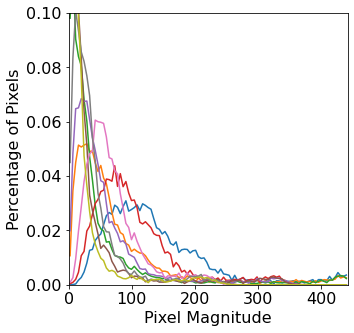

In [63]:
fig = plot_dist(dist, dataset_name='Cityscapes')
fig.savefig('figures/cityscapes_rgb_histogram_small.eps', format='eps')

In [48]:
dist_scene = get_dist('../configs/scenenet_rgbd.yaml', '../datasets/scenenet')

1it [00:00,  9.83it/s]

Using RGB-D input
Found 291919 val images


100it [00:10,  9.13it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 291919 val images


100it [00:11,  9.00it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 291919 val images


100it [00:10,  9.13it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 291919 val images


100it [00:10,  9.50it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 291919 val images


100it [00:12,  8.11it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 291919 val images


100it [00:10,  9.78it/s]
2it [00:00, 10.55it/s]

Using RGB-D input
Found 291919 val images


100it [00:10,  9.60it/s]
1it [00:00,  9.97it/s]

Using RGB-D input
Found 291919 val images


100it [00:12,  8.04it/s]
1it [00:00,  9.75it/s]

Using RGB-D input
Found 291919 val images


100it [00:10,  9.34it/s]


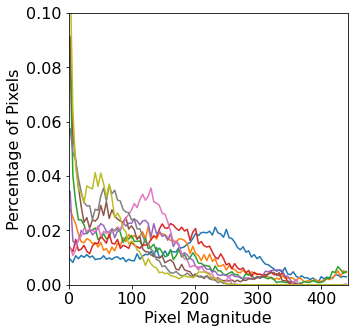

In [64]:
fig = plot_dist(dist_scene, dataset_name='Scenenet')
fig.savefig('figures/scenenet_rgb_histogram_small.eps', format='eps')

## Network Performance

In [11]:
model_configs = model_utils.get_all_models("../run/")
len(model_configs)

91

In [141]:
low_light_models = [ \
                    #Bright models 
                   '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml',
                    '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml',
                   '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml',
                    #Low-light models
                   '../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml']

In [90]:
gain = [1.0, 0.66, 0.33]
gamma = [1.0, 2.0, 3.0]

failed = []

metric_dict = {'RGB': { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}} ,
               'RGBD' : { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}}}

for index, cfg_filepath in enumerate(low_light_models):
    try:
        print(cfg_filepath)
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        for i in gain:
            for j in gamma:
                low = "low-light" if index>3 else "normal"
                
                cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                    'DATASET.DARKEN.GAIN', float(i),
                                    'DATASET.DARKEN.GAMMA', float(j)])
        
                model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
                checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
                
                result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report_gain{:3.2f}_gamma{:3.2f}.txt'.format(float(i), float(j)))
                checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
                if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
                    with open(result_file, 'r') as fp:
                        metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                        metrics = json.loads('{' + metric_str + '}')
                else:
                    metrics = {'mIoU': 0}
                    print("Failed to load {}".format(result_file))
                    #metrics = model_utils.test_model(cfg, result_file)

                metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME][i][j] = metrics['mIoU']
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)
        

../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml
../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml
../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml
../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml


In [101]:
from torchvision import transforms

def bar_plot(cfg, img_path, depth_path, label_path, dataset_name='cityscapes'):
    fig = plt.figure(figsize=(12, 12))
    
    font = {'size'   : 14}
    matplotlib.rc('font', **font)
    
    index = 1
    for i in gain:
        for j in gamma:
            cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                'DATASET.DARKEN.GAIN', float(i),
                                'DATASET.DARKEN.GAMMA', float(j)])
            dataset = make_dataset(cfg, 'val')
            sample = dataset.loader.load_sample(img_path, depth_path, label_path)
            sample['image'] = transforms.ToPILImage()(dataset.loader.invert_normalization(sample['image']))
            
            f = tr.UnDarken(cfg)
            sample = f(sample)

            plt.subplot(len(gain)*2, len(gamma)*2, index)
            plt.imshow(sample['image'])
            plt.title("$G = {},~\gamma = {}$".format(i, j))
            plt.axis('off')
            index += 1

            labels = ['scenenet', 'cityscapes']

            y_pos = np.arange(2)
            width = 0.20

            ax1 = plt.subplot(len(gain)*2, len(gamma)*2, index)
            ax1.bar(-2*width, [metric_dict['RGB']['low-light'][dataset_name][i][j]],
                    width=width, color='midnightblue', label="rgb low-light")
            ax1.bar(-width, [metric_dict['RGBD']['low-light'][dataset_name][i][j]] ,
                    width=width, color='darkred', label="rgbd low-light")
            ax1.bar(0, [metric_dict['RGB']['normal'][dataset_name][i][j]],
                    width=width, color='blue', label="rgb")
            ax1.bar(width, [metric_dict['RGBD']['normal'][dataset_name][i][j]],
                    width=width, color='red', label="rgbd")

            plt.ylim((0, .6))
            ax1.get_yaxis().set_visible(False)
            ax1.get_xaxis().set_visible(False)

            for p in ax1.patches:
                if p.get_height() > 0 :
                    ax1.annotate("{:.2f}".format(p.get_height()), (p.get_x()+0.05, p.get_height()+0.05), rotation=90)

            index += 1

    ax1.legend()
    
    return fig

Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


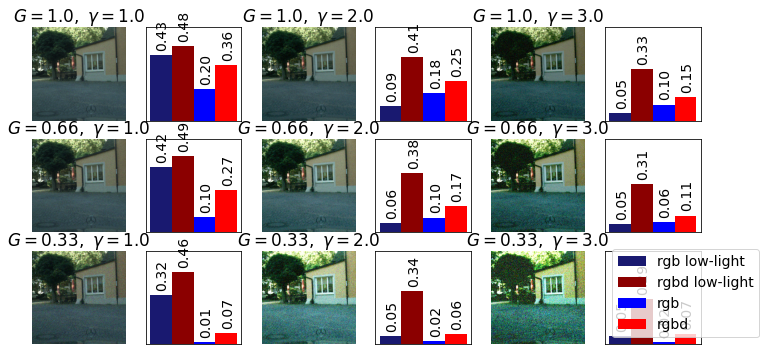

In [102]:
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/cityscapes_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/'])

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(5)
    
fig = bar_plot(cfg, img_path, depth_path, label_path, dataset_name='cityscapes')
fig.savefig('figures/cityscapes_result_grid.eps', format='eps', dpi=300)

Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images
Using RGB-D input
Found 291919 val images


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


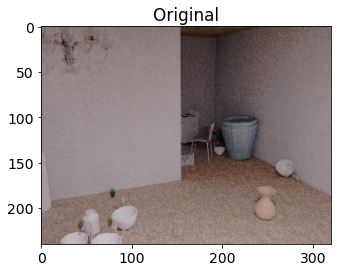

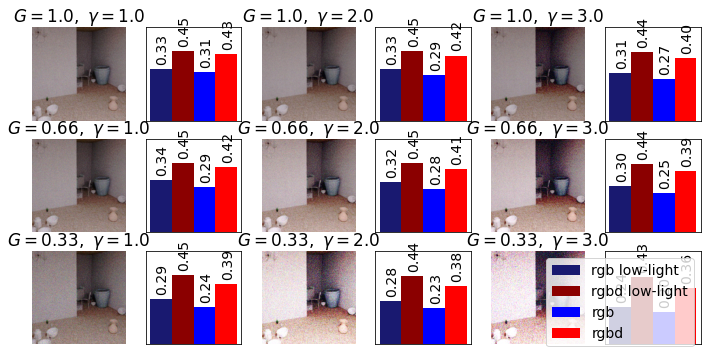

In [103]:
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/scenenet_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/scenenet/'])

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(175)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original") 
    
fig = bar_plot(cfg, img_path, depth_path, label_path, dataset_name='scenenet')
fig.savefig('figures/scenenet_result_grid.eps', format='eps')

In [146]:
def get_metrics(report='validation_report.txt'):
    failed = []

    metric_dict = {'RGB': { 'low-light': { 'scenenet': 0.0,
                                            'cityscapes': 0.0},
                            'normal': { 'scenenet': 0.0,
                                            'cityscapes': 0.0}} ,
                   'RGBD' : { 'low-light': { 'scenenet': 0.0,
                                            'cityscapes': 0.0},
                            'normal': { 'scenenet': 0.0,
                                            'cityscapes': 0.0}}}

    for index, cfg_filepath in enumerate(low_light_models):
        try:
#             print(cfg_filepath)
            cfg = model_utils.match_cfg_versions(cfg_filepath)
            cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                                 'TEST.MAX_ITER', 1000,
                                 'MODEL.PRETRAINED', "",
                                 'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

            low = "low-light" if index>3 else "normal"

            cfg.merge_from_list(['DATASET.DARKEN.DARKEN', False])

            model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
            checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))

            result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, report)
            if os.path.exists(result_file):
                with open(result_file, 'r') as fp:
                    metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                    metrics = json.loads('{' + metric_str + '}')
#                     print("Success on {} : {} ".format(cfg_filepath, metrics['mIoU']))
            else:
                metrics = {'mIoU': 0}
                print("Failed to load {}".format(result_file))
                #metrics = model_utils.test_model(cfg, result_file)

            metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME] = metrics['mIoU']

        except Exception as e:
            print(e)
            print(cfg_filepath)
            failed.append(cfg_filepath)
            
    return metric_dict

In [85]:
def make_bar_plot(ax1, metrics, labels, dataset='cityscapes'):
    y_pos = np.arange(len(metrics))
    width = 0.2
    
    for i, metric_dict in enumerate(metrics):
        ax1.bar(y_pos[i] - 2*width, [metric_dict['RGB']['low-light'][dataset]], 
                width=width, color='midnightblue', label='rgb low-light')
        ax1.bar(y_pos[i] - width, [metric_dict['RGBD']['low-light'][dataset]], 
                width=width, color='darkred', label='rgbd low-light')
        ax1.bar(y_pos[i], [metric_dict['RGB']['normal'][dataset]], 
                width=width, color='blue', label='rgb')
        ax1.bar(y_pos[i] + width, [metric_dict['RGBD']['normal'][dataset]],
                width=width, color='red', label='rgbd')

        plt.ylim((0, .7))
        plt.ylabel('mIoU')

    for p in ax1.patches:
        if p.get_height() > 0 :
            ax1.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1.005+.05, p.get_height() * 1.005+0.05), rotation=90)
    
    ax1.set_xticks(y_pos)
    ax1.set_xticklabels(labels)

Using RGB-D input
Found 500 val images
Using RGB-D input
Found 291919 val images
../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml
../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml
../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml
../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml
../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
../run/cit

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


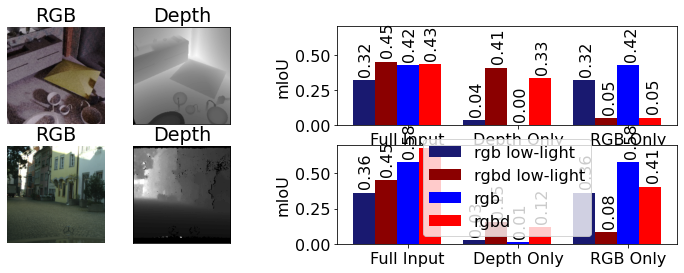

In [86]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(2, 4, width_ratios=[2, 2, 1, 7]) 

cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/cityscapes_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/'])

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(10)
sample_city = dataset.loader.load_sample(img_path, depth_path, label_path)
sample_city['image'] = dataset.loader.invert_normalization(sample_city['image'])

cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/scenenet_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/scenenet/'])

dataset = make_dataset(cfg, 'val')
sample = dataset.loader.load_sample('../datasets/scenenet/val/0/608/photo/0.jpg', '../datasets/scenenet/val/0/608/depth/0.png', 
                                    '../datasets/scenenet/val/0/608/semantic/0.png')
sample['image'] = dataset.loader.invert_normalization(sample['image'])

base_metrics = get_metrics('validation_report.txt')
depth_metrics = get_metrics('validation_report_depth_only.txt')
rgb_metrics = get_metrics('validation_report_no_depth.txt')
metrics = [base_metrics, depth_metrics, rgb_metrics]
labels = ["Full Input", "Depth Only", "RGB Only"]

ax = plt.subplot(gs[0])
plt.title("RGB")
plt.imshow(sample['image'][:, :, :3])
ax.set_ylabel("SceneNet", rotation=0, size='large')
plt.axis('off')

ax = plt.subplot(gs[1])
plt.title("Depth")
plt.imshow(sample['image'][:, :, 3:], cmap=plt.get_cmap('gray'))
# plt.colorbar(fraction=0.046, pad=0.04)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax1 = plt.subplot(gs[3])
make_bar_plot(ax1, metrics, labels, dataset='scenenet')

ax = plt.subplot(gs[4])
plt.title("RGB")
plt.imshow(sample_city['image'][:, :, :3])
ax.set_ylabel("Cityscapes", rotation=0, size='large')
plt.axis('off')

ax = plt.subplot(gs[5])
plt.title("Depth")
# log_depth = sample_city['image'][:, :, 3:]
# log_depth[log_depth>0] = np.log(log_depth[log_depth>0])
plt.imshow(sample_city['image'][:, :, 3:], cmap=plt.get_cmap('gray'), clim=[0, 75])
# plt.colorbar(fraction=0.046, pad=0.04)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax1 = plt.subplot(gs[7])
make_bar_plot(ax1, metrics, labels, dataset='cityscapes')
ax1.legend(['rgb low-light', 'rgbd low-light', 'rgb', 'rgbd'])

fig.savefig('figures/ablation_study_gray.eps', format='eps')

In [162]:
def line_plot(ax, result, samples, dataset='cityscapes'):
#     samples = sigma
#     dataset = 'cityscapes'
#     result = 'validation_report_sigma{:f}.txt'

    rgb_low = []
    rgbd_low = []
    rgb = []
    rgbd = []
    for i in samples:
        
        result_file = ('../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/' + result).format(float(i))
        if os.path.exists(result_file):
            with open(result_file, 'r') as fp:
                metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                metrics = json.loads('{' + metric_str + '}')
                print("Success on {} : {} ".format(result_file, metrics['mIoU']))
                rgb.append(metrics['mIoU'])
                
        metric_dict = get_metrics(result.format(float(i)))
#         rgb.append(metrics['RGB']['normal'][dataset])
        rgbd.append(metric_dict['RGBD']['normal'][dataset])

        rgb_low.append(metric_dict['RGB']['low-light'][dataset])
        rgbd_low.append(metric_dict['RGBD']['low-light'][dataset])

    ax.plot(samples, rgb_low, '.-', color='midnightblue', label='rgb low-light')
    ax.plot(samples, rgbd_low, '.-', color='darkred', label='rgbd low-light')
    ax.plot(samples, rgb, '.-', color='blue', label='rgb')
    ax.plot(samples, rgbd, '.-', color='red', label='rgbd')
    #     return fig

Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_sigma0.010000.txt : 0.5509108986444564 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_sigma0.022500.txt : 0.4366436075744488 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_sigma0.035000.txt : 0.2965885512249375 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_sigma0.047500.txt : 0.1848411388103862 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xcep

/home/cecilia/pytorch-deeplab-xception/deeplab3/utils/model_utils.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  model_cfg = yaml.load(f)


Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_gain0.66_no_noise.txt : 0.5663738168096862 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_gain0.33_no_noise.txt : 0.5228006672845573 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_gamma1.00_no_noise.txt : 0.5783838000260823 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/validation_report_gamma2.00_no_noise.txt : 0.5139763879960016 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITY

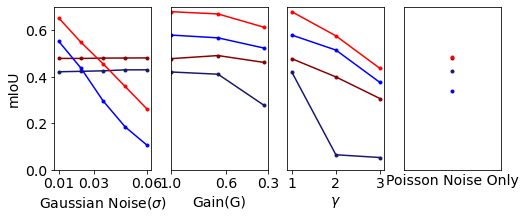

In [163]:
sigma = np.linspace(0.01, 0.06, 5)

fig = plt.figure(figsize=(8, 3))

ax = plt.subplot(1,4,1)
line_plot(ax, 'validation_report_sigma{:f}.txt', sigma, dataset='cityscapes')
plt.ylim(0, .7)
ax.set_xticks([0.01, 0.03, 0.06])
# ax.set_xticklabels(labels)
plt.ylabel('mIoU')
plt.xlabel('Gaussian Noise($\sigma$)')

ax = plt.subplot(1,4,2)
line_plot(ax, 'validation_report_gain{:3.2f}_no_noise.txt', gain, dataset='cityscapes')
plt.ylim(0, .7)
ax.get_yaxis().set_visible(False)
plt.xlim(1.0, 0.33)
ax.set_xticks([1, 0.6, 0.3])
plt.xlabel('Gain(G)')

ax = plt.subplot(1,4,3)
line_plot(ax, 'validation_report_gamma{:3.2f}_no_noise.txt', gamma, dataset='cityscapes')
plt.ylim(0, .7)
ax.get_yaxis().set_visible(False)
ax.set_xticks([1, 2, 3])
plt.xlabel('$\gamma$')

ax = plt.subplot(1,4,4)
line_plot(ax, 'validation_report_poisson_only.txt', [0], dataset='cityscapes')
plt.ylim(0, .7)
ax.get_yaxis().set_visible(False)
ax.set_xticks([])
plt.xlabel('Poisson Noise Only')


# plt.legend()

# plt.tight_layout()
fig.savefig('figures/cityscapes_sensitivity_long.eps', format='eps', bbox_inches = "tight")

In [159]:
def line_plot(ax, result, samples, dataset='cityscapes'):
#     samples = sigma
#     dataset = 'cityscapes'
#     result = 'validation_report_sigma{:f}.txt'

    rgb_low = []
    rgbd_low = []
    rgb = []
    rgbd = []
    for i in samples:
        
        result_file = ('../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/' + result).format(float(i))
        if os.path.exists(result_file):
            with open(result_file, 'r') as fp:
                metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                metrics = json.loads('{' + metric_str + '}')
                print("Success on {} : {} ".format(result_file, metrics['mIoU']))
                rgb.append(metrics['mIoU'])
                
        metric_dict = get_metrics(result.format(float(i)))
#         rgb.append(metrics['RGB']['normal'][dataset])
        rgbd.append(metric_dict['RGBD']['normal'][dataset])

        rgb_low.append(metric_dict['RGB']['low-light'][dataset])
        rgbd_low.append(metric_dict['RGBD']['low-light'][dataset])

    ax.plot(samples, rgb_low, '.-', color='midnightblue', label='rgb low-light')
    ax.plot(samples, rgbd_low, '.-', color='darkred', label='rgbd low-light')
    ax.plot(samples, rgb, '.-', color='blue', label='rgb')
    ax.plot(samples, rgbd, '.-', color='red', label='rgbd')

Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_sigma0.010000.txt : 0.3846663258378066 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_sigma0.022500.txt : 0.3570482521908129 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_sigma0.035000.txt : 0.3419945418874449 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_sigma0.047500.txt : 0.3253148724075749 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_sigma0.060000.txt : 0.304312808301278

/home/cecilia/pytorch-deeplab-xception/deeplab3/utils/model_utils.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  model_cfg = yaml.load(f)


Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_gain0.66_no_noise.txt : 0.3845762448502167 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_gain0.33_no_noise.txt : 0.3216217240596659 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_gamma1.00_no_noise.txt : 0.4159146363381231 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/validation_report_gamma2.00_no_noise.txt : 0.37974056633388165 
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on ../run/scenenet/scenenet_rgb_xception/2020_09_17

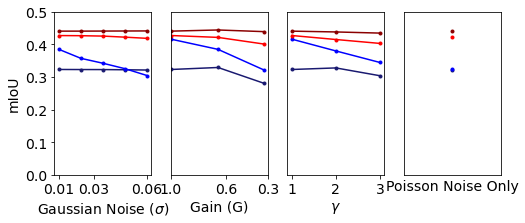

In [161]:
fig = plt.figure(figsize=(8, 3))

ax = plt.subplot(1,4,1)
line_plot(ax, 'validation_report_sigma{:f}.txt', sigma, dataset='scenenet')
plt.ylim(0, .5)
ax.set_xticks([0.01, 0.03, 0.06])
# ax.set_xticklabels(labels)
plt.ylabel('mIoU')
plt.xlabel('Gaussian Noise ($\sigma$)')

ax = plt.subplot(1,4,2)
line_plot(ax, 'validation_report_gain{:3.2f}_no_noise.txt', gain, dataset='scenenet')
plt.ylim(0, .5)
ax.get_yaxis().set_visible(False)
plt.xlim(1.0, 0.33)
ax.set_xticks([1, 0.6, 0.3])
plt.xlabel('Gain (G)')

ax = plt.subplot(1,4,3)
line_plot(ax, 'validation_report_gamma{:3.2f}_no_noise.txt', gamma, dataset='scenenet')
plt.ylim(0, .5)
ax.get_yaxis().set_visible(False)
ax.set_xticks([1, 2, 3])
plt.xlabel('$\gamma$')

ax = plt.subplot(1,4,4)
line_plot(ax, 'validation_report_poisson_only.txt', [0], dataset='scenenet')
plt.ylim(0, .5)
ax.get_yaxis().set_visible(False)
ax.set_xticks([])
plt.xlabel('Poisson Noise Only')


# plt.legend()

fig.savefig('figures/scenenet_sensitivity_long.eps', format='eps', bbox_inches = "tight")